In [ ]:
# CrossFit 동작 분류 시계열 분석 프로젝트

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Input, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
import pickle
import os
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.style.use('default')

print("=== CrossFit 동작 분류 시계열 분석 프로젝트 ===")
print("필요한 라이브러리 로드 완료!")

=== CrossFit 동작 분류 시계열 분석 프로젝트 ===
필요한 라이브러리 로드 완료!


In [2]:
# ==================== 1단계: 데이터 로드 및 탐색 ====================
print("\n1단계: 데이터 로드 및 탐색")

# 운동별 정보 정의
exercise_info = {
    'deadlift': {
        'labels': {0: 'Normal', 1: 'Hip Error', 2: 'Arm Posture Error'},
        'file': './deadlift.csv'
    },
    'squat': {
        'labels': {0: 'Normal', 1: 'Hip Error', 2: 'Butt Down Error', 3: 'Heel Error'},
        'file': './squat.csv'
    },
    'clean': {
        'labels': {0: 'Normal', 1: 'Hip Error', 2: 'Arm Movement Error', 3: 'Full Movement Error'},
        'file': './clean.csv'
    },
    'press': {
        'labels': {0: 'Normal', 1: 'Overhead Error', 2: 'Arm Movement Error', 3: 'Elbow-Shoulder Inactive Error'},
        'file': './press.csv'
    }
}

# 데이터 로드 함수
def load_and_explore_data(file_path):
    """데이터 로드 및 기본 탐색"""
    try:
        df = pd.read_csv(file_path)
        print(f"\n파일: {file_path}")
        print(f"데이터 형태: {df.shape}")
        print(f"Session 수: {df['session_id'].nunique()}")
        print(f"라벨 분포:\n{df['crossfit_label'].value_counts().sort_index()}")

        # Session별 길이 분포
        session_lengths = df.groupby('session_id').size()
        print(f"Session 길이 - 평균: {session_lengths.mean():.1f}, 최소: {session_lengths.min()}, 최대: {session_lengths.max()}")

        return df, session_lengths
    except FileNotFoundError:
        print(f"파일을 찾을 수 없습니다: {file_path}")
        return None, None

# 샘플 데이터 생성 (실제 파일이 없는 경우를 위한 예시)
def create_sample_data(exercise_name, n_sessions=400):
    """샘플 데이터 생성"""
    np.random.seed(42)

    # 라벨 수 결정
    n_labels = len(exercise_info[exercise_name]['labels'])

    all_data = []
    session_id = 0

    for label in range(n_labels):
        sessions_per_label = n_sessions // n_labels

        for _ in range(sessions_per_label):
            # 세션 길이 랜덤 생성 (300~400 프레임으로 증가)
            session_length = np.random.randint(300, 401)

            # 기본 skeleton 좌표 생성 (실제 데이터와 유사한 범위)
            base_coords = np.random.uniform(300, 1200, 34)  # 34개 좌표 (x,y 17개 관절)

            # 시간에 따른 변화 추가
            for frame in range(session_length):
                # 시간에 따른 자연스러운 변화
                noise = np.random.normal(0, 10, 34)
                coords = base_coords + noise + np.sin(frame * 0.1) * 20

                # 라벨별 특징 추가
                if label == 1:  # Hip Error
                    coords[24:26] += np.random.normal(0, 50)  # Hip 좌표 변화
                elif label == 2:  # Arm/Other Error
                    coords[4:12] += np.random.normal(0, 30)  # Arm 좌표 변화
                elif label == 3 and n_labels > 3:  # Additional Error
                    coords[16:24] += np.random.normal(0, 40)  # Leg 좌표 변화

                row_data = coords.tolist() + [label, session_id]
                all_data.append(row_data)

            session_id += 1

    # 컬럼명 생성
    coord_columns = ['LShoulder_x', 'LShoulder_y', 'RShoulder_x', 'RShoulder_y',
                     'LElbow_x', 'LElbow_y', 'RElbow_x', 'RElbow_y',
                     'LWrist_x', 'LWrist_y', 'RWrist_x', 'RWrist_y',
                     'LHip_x', 'LHip_y', 'RHip_x', 'RHip_y',
                     'LKnee_x', 'LKnee_y', 'RKnee_x', 'RKnee_y',
                     'LAnkle_x', 'LAnkle_y', 'RAnkle_x', 'RAnkle_y',
                     'Hip_x', 'Hip_y', 'LBigToe_x', 'LBigToe_y',
                     'RBigToe_x', 'RBigToe_y', 'LHeel_x', 'LHeel_y',
                     'RHeel_x', 'RHeel_y']

    columns = coord_columns + ['crossfit_label', 'session_id']

    df = pd.DataFrame(all_data, columns=columns)
    return df

# 데이터 로드 또는 샘플 데이터 생성
datasets = {}
for exercise_name, info in exercise_info.items():
    df, session_lengths = load_and_explore_data(info['file'])
    if df is None:
        print(f"{exercise_name} 파일이 없어 샘플 데이터를 생성합니다.")
        df = create_sample_data(exercise_name)
        session_lengths = df.groupby('session_id').size()

    datasets[exercise_name] = {
        'data': df,
        'session_lengths': session_lengths
    }


1단계: 데이터 로드 및 탐색

파일: ./deadlift.csv
데이터 형태: (101121, 36)
Session 수: 320
라벨 분포:
crossfit_label
0    33958
1    41286
2    25877
Name: count, dtype: int64
Session 길이 - 평균: 316.0, 최소: 219, 최대: 540

파일: ./squat.csv
데이터 형태: (64928, 36)
Session 수: 344
라벨 분포:
crossfit_label
0    20376
1    20944
2    10992
3    12616
Name: count, dtype: int64
Session 길이 - 평균: 188.7, 최소: 103, 최대: 289

파일: ./clean.csv
데이터 형태: (115764, 36)
Session 수: 448
라벨 분포:
crossfit_label
0    48600
1    17492
2    21837
3    27835
Name: count, dtype: int64
Session 길이 - 평균: 258.4, 최소: 162, 최대: 369

파일: ./press.csv
데이터 형태: (121170, 36)
Session 수: 328
라벨 분포:
crossfit_label
0    44756
1    26728
2    15175
3    34511
Name: count, dtype: int64
Session 길이 - 평균: 369.4, 최소: 239, 최대: 551


In [3]:
# ==================== 2단계: 데이터 전처리 ====================
print("\n2단계: 데이터 전처리")

def preprocess_data(df, exercise_name):
    """데이터 전처리 함수"""
    df_processed = df.copy()

    # 좌표 컬럼만 선택 (crossfit_label, session_id 제외)
    coord_columns = [col for col in df.columns if col not in ['crossfit_label', 'session_id']]

    # 좌표 데이터 표준화
    scaler = StandardScaler()
    df_processed[coord_columns] = scaler.fit_transform(df_processed[coord_columns])

    print(f"{exercise_name} - 좌표 데이터 표준화 완료")
    print(f"표준화 후 좌표 범위: {df_processed[coord_columns].min().min():.3f} ~ {df_processed[coord_columns].max().max():.3f}")

    return df_processed, scaler

# 모든 데이터셋 전처리
scalers = {}
for exercise_name in datasets.keys():
    datasets[exercise_name]['data'], scalers[exercise_name] = preprocess_data(
        datasets[exercise_name]['data'], exercise_name
    )


2단계: 데이터 전처리
deadlift - 좌표 데이터 표준화 완료
표준화 후 좌표 범위: -2.377 ~ 3.487
squat - 좌표 데이터 표준화 완료
표준화 후 좌표 범위: -2.193 ~ 3.745
clean - 좌표 데이터 표준화 완료
표준화 후 좌표 범위: -2.768 ~ 3.458
press - 좌표 데이터 표준화 완료
표준화 후 좌표 범위: -2.243 ~ 3.823


In [4]:
# ==================== 3단계: 시계열 데이터 준비 ====================
print("\n3단계: 시계열 데이터 준비")

# 세션당 프레임 수 상세 분석
print("=== 각 운동별 세션당 프레임 수 분석 ===")
session_frame_analysis = {}

for exercise_name, data in datasets.items():
    session_lengths = data['session_lengths']

    print(f"\n{exercise_name.upper()}:")
    print(f"  총 세션 수: {len(session_lengths)}")
    print(f"  세션당 평균 프레임 수: {session_lengths.mean():.1f}")
    print(f"  세션당 중간값 프레임 수: {session_lengths.median():.1f}")
    print(f"  최소 프레임 수: {session_lengths.min()}")
    print(f"  최대 프레임 수: {session_lengths.max()}")
    print(f"  표준편차: {session_lengths.std():.1f}")

    # 분위수 정보
    q25, q75 = np.percentile(session_lengths, [25, 75])
    print(f"  25% 분위수: {q25:.1f}")
    print(f"  75% 분위수: {q75:.1f}")

    session_frame_analysis[exercise_name] = {
        'mean': session_lengths.mean(),
        'median': session_lengths.median(),
        'min': session_lengths.min(),
        'max': session_lengths.max(),
        'q25': q25,
        'q75': q75
    }

# 전체 데이터 기반으로 최적 시퀀스 길이 결정
all_session_lengths = []
for data in datasets.values():
    all_session_lengths.extend(data['session_lengths'].tolist())

overall_median = np.median(all_session_lengths)
overall_mean = np.mean(all_session_lengths)

print(f"\n=== 전체 데이터 기반 분석 ===")
print(f"전체 평균 프레임 수: {overall_mean:.1f}")
print(f"전체 중간값 프레임 수: {overall_median:.1f}")

# 적응적 시퀀스 길이 결정
if overall_median <= 50:
    optimal_sequence_length = int(overall_median * 0.9)
elif overall_median <= 150:
    optimal_sequence_length = int(overall_median * 0.8)
else:
    # 긴 시퀀스의 경우 더 보수적으로 접근하되 충분한 길이 확보
    optimal_sequence_length = min(int(overall_median * 0.7), 300)  # 최대 300으로 제한

print(f"권장 시퀀스 길이: {optimal_sequence_length}")

def create_sequences(df, sequence_length=None):
    """시계열 시퀀스 생성 (적응적 길이 조정)"""
    if sequence_length is None:
        sequence_length = optimal_sequence_length

    coord_columns = [col for col in df.columns if col not in ['crossfit_label', 'session_id']]

    sequences = []
    labels = []

    for session_id in df['session_id'].unique():
        session_data = df[df['session_id'] == session_id]

        # 좌표 데이터와 라벨 추출
        coords = session_data[coord_columns].values
        label = session_data['crossfit_label'].iloc[0]

        # 시퀀스 길이 조정
        if len(coords) >= sequence_length:
            # 길면 자르기 (중간 부분 사용)
            start_idx = (len(coords) - sequence_length) // 2
            coords = coords[start_idx:start_idx + sequence_length]
        else:
            # 짧으면 패딩 (앞쪽 값으로 패딩)
            padding = np.tile(coords[0], (sequence_length - len(coords), 1))
            coords = np.vstack([padding, coords])

        sequences.append(coords)
        labels.append(label)

    return np.array(sequences), np.array(labels)

# 시퀀스 생성
sequences_data = {}

print(f"\n=== 시퀀스 길이 {optimal_sequence_length}로 데이터 생성 ===")
for exercise_name in datasets.keys():
    X, y = create_sequences(datasets[exercise_name]['data'], optimal_sequence_length)
    sequences_data[exercise_name] = {'X': X, 'y': y}
    print(f"{exercise_name} - 시퀀스 형태: {X.shape}, 라벨 형태: {y.shape}")


3단계: 시계열 데이터 준비
=== 각 운동별 세션당 프레임 수 분석 ===

DEADLIFT:
  총 세션 수: 320
  세션당 평균 프레임 수: 316.0
  세션당 중간값 프레임 수: 299.5
  최소 프레임 수: 219
  최대 프레임 수: 540
  표준편차: 64.3
  25% 분위수: 275.0
  75% 분위수: 347.0

SQUAT:
  총 세션 수: 344
  세션당 평균 프레임 수: 188.7
  세션당 중간값 프레임 수: 182.0
  최소 프레임 수: 103
  최대 프레임 수: 289
  표준편차: 50.6
  25% 분위수: 153.0
  75% 분위수: 215.0

CLEAN:
  총 세션 수: 448
  세션당 평균 프레임 수: 258.4
  세션당 중간값 프레임 수: 254.0
  최소 프레임 수: 162
  최대 프레임 수: 369
  표준편차: 46.1
  25% 분위수: 226.0
  75% 분위수: 292.0

PRESS:
  총 세션 수: 328
  세션당 평균 프레임 수: 369.4
  세션당 중간값 프레임 수: 352.0
  최소 프레임 수: 239
  최대 프레임 수: 551
  표준편차: 76.4
  25% 분위수: 326.0
  75% 분위수: 430.0

=== 전체 데이터 기반 분석 ===
전체 평균 프레임 수: 279.8
전체 중간값 프레임 수: 276.0
권장 시퀀스 길이: 193

=== 시퀀스 길이 193로 데이터 생성 ===
deadlift - 시퀀스 형태: (320, 193, 34), 라벨 형태: (320,)
squat - 시퀀스 형태: (344, 193, 34), 라벨 형태: (344,)
clean - 시퀀스 형태: (448, 193, 34), 라벨 형태: (448,)
press - 시퀀스 형태: (328, 193, 34), 라벨 형태: (328,)


In [5]:
# ==================== 4단계: 모델 정의 ====================
print("\n4단계: 모델 정의")

def create_keras_model(input_shape, n_classes, model_type='lstm'):
    """Keras 모델 생성 함수 (KerasClassifier용)"""
    if model_type == 'lstm':
        model = Sequential([
            LSTM(64, return_sequences=True, input_shape=input_shape),
            Dropout(0.2),
            LSTM(32, return_sequences=False),
            Dropout(0.2),
            Dense(32, activation='relu'),
            Dense(n_classes, activation='softmax')
        ])
    elif model_type == 'cnn_lstm':
        model = Sequential([
            Conv1D(64, 3, activation='relu', input_shape=input_shape),
            Conv1D(64, 3, activation='relu'),
            MaxPooling1D(2),
            LSTM(32, return_sequences=False),
            Dropout(0.2),
            Dense(32, activation='relu'),
            Dense(n_classes, activation='softmax')
        ])
    elif model_type == 'bidirectional_lstm':
        model = Sequential([
            Bidirectional(LSTM(32, return_sequences=True), input_shape=input_shape),
            Dropout(0.2),
            Bidirectional(LSTM(16, return_sequences=False)),
            Dropout(0.2),
            Dense(32, activation='relu'),
            Dense(n_classes, activation='softmax')
        ])
    elif model_type == 'cnn':
        model = Sequential([
            Conv1D(64, 3, activation='relu', input_shape=input_shape),
            Conv1D(64, 3, activation='relu'),
            MaxPooling1D(2),
            Conv1D(32, 3, activation='relu'),
            GlobalMaxPooling1D(),
            Dense(32, activation='relu'),
            Dropout(0.2),
            Dense(n_classes, activation='softmax')
        ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


4단계: 모델 정의


In [6]:
# ==================== 5단계: Nested Cross-Validation을 통한 모델 훈련 및 평가 ====================
print("\n5단계: Nested Cross-Validation을 통한 모델 훈련 및 평가")

def nested_cross_validation(X, y, n_classes, model_type='lstm', outer_cv=5, inner_cv=3):
    """Nested Cross-Validation 수행"""

    # 외부 CV 설정
    outer_cv_splitter = StratifiedKFold(n_splits=outer_cv, shuffle=True, random_state=42)
    inner_cv_splitter = StratifiedKFold(n_splits=inner_cv, shuffle=True, random_state=42)

    outer_scores = []
    fold_details = []

    print(f"  {model_type} 모델 Nested CV 시작...")

    for fold_idx, (train_outer_idx, test_outer_idx) in enumerate(outer_cv_splitter.split(X, y)):
        print(f"    Outer Fold {fold_idx + 1}/{outer_cv}")

        # 외부 fold 데이터 분할
        X_train_outer, X_test_outer = X[train_outer_idx], X[test_outer_idx]
        y_train_outer, y_test_outer = y[train_outer_idx], y[test_outer_idx]

        # 내부 CV로 하이퍼파라미터 튜닝 (여기서는 간단히 모델 성능만 평가)
        inner_scores = []

        for inner_fold_idx, (train_inner_idx, val_inner_idx) in enumerate(inner_cv_splitter.split(X_train_outer, y_train_outer)):
            X_train_inner = X_train_outer[train_inner_idx]
            X_val_inner = X_train_outer[val_inner_idx]
            y_train_inner = y_train_outer[train_inner_idx]
            y_val_inner = y_train_outer[val_inner_idx]

            # 원-핫 인코딩
            y_train_inner_cat = to_categorical(y_train_inner, n_classes)
            y_val_inner_cat = to_categorical(y_val_inner, n_classes)

            # 모델 생성 및 훈련
            model = create_keras_model(input_shape=(X.shape[1], X.shape[2]),
                                     n_classes=n_classes,
                                     model_type=model_type)

            # 콜백 설정
            callbacks = [
                EarlyStopping(patience=10, restore_best_weights=True, verbose=0),
                ReduceLROnPlateau(patience=5, factor=0.5, verbose=0)
            ]

            # 훈련
            history = model.fit(
                X_train_inner, y_train_inner_cat,
                validation_data=(X_val_inner, y_val_inner_cat),
                epochs=50,
                batch_size=32,
                callbacks=callbacks,
                verbose=0
            )

            # 검증 점수
            val_loss, val_acc = model.evaluate(X_val_inner, y_val_inner_cat, verbose=0)
            inner_scores.append(val_acc)

        # 내부 CV 평균 점수
        inner_mean_score = np.mean(inner_scores)

        # 외부 테스트 셋에서 최종 평가
        # 전체 outer 훈련 데이터로 모델 재훈련
        y_train_outer_cat = to_categorical(y_train_outer, n_classes)
        y_test_outer_cat = to_categorical(y_test_outer, n_classes)

        final_model = create_keras_model(input_shape=(X.shape[1], X.shape[2]),
                                       n_classes=n_classes,
                                       model_type=model_type)

        callbacks = [
            EarlyStopping(patience=10, restore_best_weights=True, verbose=0),
            ReduceLROnPlateau(patience=5, factor=0.5, verbose=0)
        ]

        final_model.fit(
            X_train_outer, y_train_outer_cat,
            epochs=50,
            batch_size=32,
            callbacks=callbacks,
            verbose=0
        )

        # 외부 테스트 셋 평가
        test_loss, test_acc = final_model.evaluate(X_test_outer, y_test_outer_cat, verbose=0)
        outer_scores.append(test_acc)

        fold_details.append({
            'fold': fold_idx + 1,
            'inner_cv_mean': inner_mean_score,
            'outer_test_score': test_acc
        })

        print(f"      Inner CV 평균: {inner_mean_score:.4f}, Outer Test: {test_acc:.4f}")

    return {
        'model_type': model_type,
        'outer_scores': outer_scores,
        'mean_score': np.mean(outer_scores),
        'std_score': np.std(outer_scores),
        'fold_details': fold_details
    }

def train_final_model(X, y, n_classes, best_model_type):
    """최고 성능 모델로 전체 데이터에 대해 최종 훈련"""

    # 데이터 분할
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # 원-핫 인코딩
    y_train_cat = to_categorical(y_train, n_classes)
    y_test_cat = to_categorical(y_test, n_classes)

    # 최고 성능 모델 생성
    model = create_keras_model(input_shape=(X.shape[1], X.shape[2]),
                             n_classes=n_classes,
                             model_type=best_model_type)

    # 콜백 설정
    callbacks = [
        EarlyStopping(patience=15, restore_best_weights=True),
        ReduceLROnPlateau(patience=7, factor=0.5)
    ]

    # 모델 훈련
    history = model.fit(
        X_train, y_train_cat,
        validation_data=(X_test, y_test_cat),
        epochs=100,
        batch_size=32,
        callbacks=callbacks,
        verbose=1
    )

    # 예측 및 평가
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    accuracy = accuracy_score(y_test, y_pred_classes)

    return {
        'model': model,
        'history': history,
        'accuracy': accuracy,
        'X_test': X_test,
        'y_test': y_test,
        'y_pred': y_pred_classes,
        'model_name': best_model_type
    }

# 각 운동별 Nested CV 수행
nested_cv_results = {}
model_types = ['lstm', 'cnn_lstm', 'bidirectional_lstm', 'cnn']

for exercise_name in datasets.keys():
    print(f"\n=== {exercise_name.upper()} 운동 Nested CV 분석 ===")

    X = sequences_data[exercise_name]['X']
    y = sequences_data[exercise_name]['y']
    n_classes = len(exercise_info[exercise_name]['labels'])

    exercise_nested_results = {}

    for model_type in model_types:
        nested_result = nested_cross_validation(X, y, n_classes, model_type, outer_cv=5, inner_cv=3)
        exercise_nested_results[model_type] = nested_result

        print(f"\n{model_type.upper()} 결과:")
        print(f"  평균 점수: {nested_result['mean_score']:.4f} ± {nested_result['std_score']:.4f}")

    nested_cv_results[exercise_name] = exercise_nested_results

# 최고 성능 모델로 최종 훈련
print("\n=== 최고 성능 모델로 최종 훈련 ===")
final_results = {}

for exercise_name, exercise_nested_results in nested_cv_results.items():
    print(f"\n{exercise_name.upper()}:")

    # 가장 좋은 모델 찾기
    best_model_type = max(exercise_nested_results.keys(),
                         key=lambda x: exercise_nested_results[x]['mean_score'])
    best_score = exercise_nested_results[best_model_type]['mean_score']

    print(f"최고 성능 모델: {best_model_type.upper()} (점수: {best_score:.4f})")

    # 최종 모델 훈련
    X = sequences_data[exercise_name]['X']
    y = sequences_data[exercise_name]['y']
    n_classes = len(exercise_info[exercise_name]['labels'])

    final_result = train_final_model(X, y, n_classes, best_model_type)
    final_results[exercise_name] = final_result

    print(f"최종 테스트 정확도: {final_result['accuracy']:.4f}")


5단계: Nested Cross-Validation을 통한 모델 훈련 및 평가

=== DEADLIFT 운동 Nested CV 분석 ===
  lstm 모델 Nested CV 시작...
    Outer Fold 1/5
      Inner CV 평균: 0.3594, Outer Test: 0.4375
    Outer Fold 2/5
      Inner CV 평균: 0.3555, Outer Test: 0.3906
    Outer Fold 3/5
      Inner CV 평균: 0.3321, Outer Test: 0.4844
    Outer Fold 4/5
      Inner CV 평균: 0.3320, Outer Test: 0.3125
    Outer Fold 5/5
      Inner CV 평균: 0.2969, Outer Test: 0.4375

LSTM 결과:
  평균 점수: 0.4125 ± 0.0581
  cnn_lstm 모델 Nested CV 시작...
    Outer Fold 1/5
      Inner CV 평균: 0.3400, Outer Test: 0.4219
    Outer Fold 2/5
      Inner CV 평균: 0.3163, Outer Test: 0.3906
    Outer Fold 3/5
      Inner CV 평균: 0.3513, Outer Test: 0.4375
    Outer Fold 4/5
      Inner CV 평균: 0.3202, Outer Test: 0.4062
    Outer Fold 5/5
      Inner CV 평균: 0.3437, Outer Test: 0.5312

CNN_LSTM 결과:
  평균 점수: 0.4375 ± 0.0494
  bidirectional_lstm 모델 Nested CV 시작...
    Outer Fold 1/5
      Inner CV 평균: 0.3671, Outer Test: 0.4062
    Outer Fold 2/5
      Inner CV 평균

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step
최종 테스트 정확도: 0.8444

PRESS:
최고 성능 모델: CNN_LSTM (점수: 0.4421)
Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.2023 - loss: 1.4151 - val_accuracy: 0.3333 - val_loss: 1.3415 - learning_rate: 0.0010
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3572 - loss: 1.3214 - val_accuracy: 0.3636 - val_loss: 1.3238 - learning_rate: 0.0010
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3037 - loss: 1.3312 - val_accuracy: 0.3485 - val_loss: 1.3300 - learning_rate: 0.0010
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3470 - loss: 1.3076 - val_accuracy: 0.3636 - val_loss: 1.3329 - learning_rate: 0.0010
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3792 - loss: 1.3045 - val_accuracy: 0.3485 - val_loss: 1.3405 - learning_rate: 0.0010
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3171 - loss: 1.3051 - val_accuracy: 0.3485 - val_loss: 1.3518 - learning_rate: 0.0010
Ep

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
최종 테스트 정확도: 0.3636



6단계: Nested CV 결과 시각화 및 분석

=== Nested Cross-Validation 결과 요약 ===

DEADLIFT:
  LSTM: 0.4125 ± 0.0581
  CNN_LSTM: 0.4375 ± 0.0494
  BIDIRECTIONAL_LSTM: 0.4469 ± 0.0459
  CNN: 0.5062 ± 0.0622

SQUAT:
  LSTM: 0.2994 ± 0.0352
  CNN_LSTM: 0.4072 ± 0.0893
  BIDIRECTIONAL_LSTM: 0.2733 ± 0.0394
  CNN: 0.7298 ± 0.0304

CLEAN:
  LSTM: 0.4908 ± 0.0666
  CNN_LSTM: 0.7543 ± 0.0969
  BIDIRECTIONAL_LSTM: 0.4798 ± 0.0417
  CNN: 0.7768 ± 0.0169

PRESS:
  LSTM: 0.3597 ± 0.0430
  CNN_LSTM: 0.4421 ± 0.0533
  BIDIRECTIONAL_LSTM: 0.3844 ± 0.0503
  CNN: 0.4337 ± 0.1200


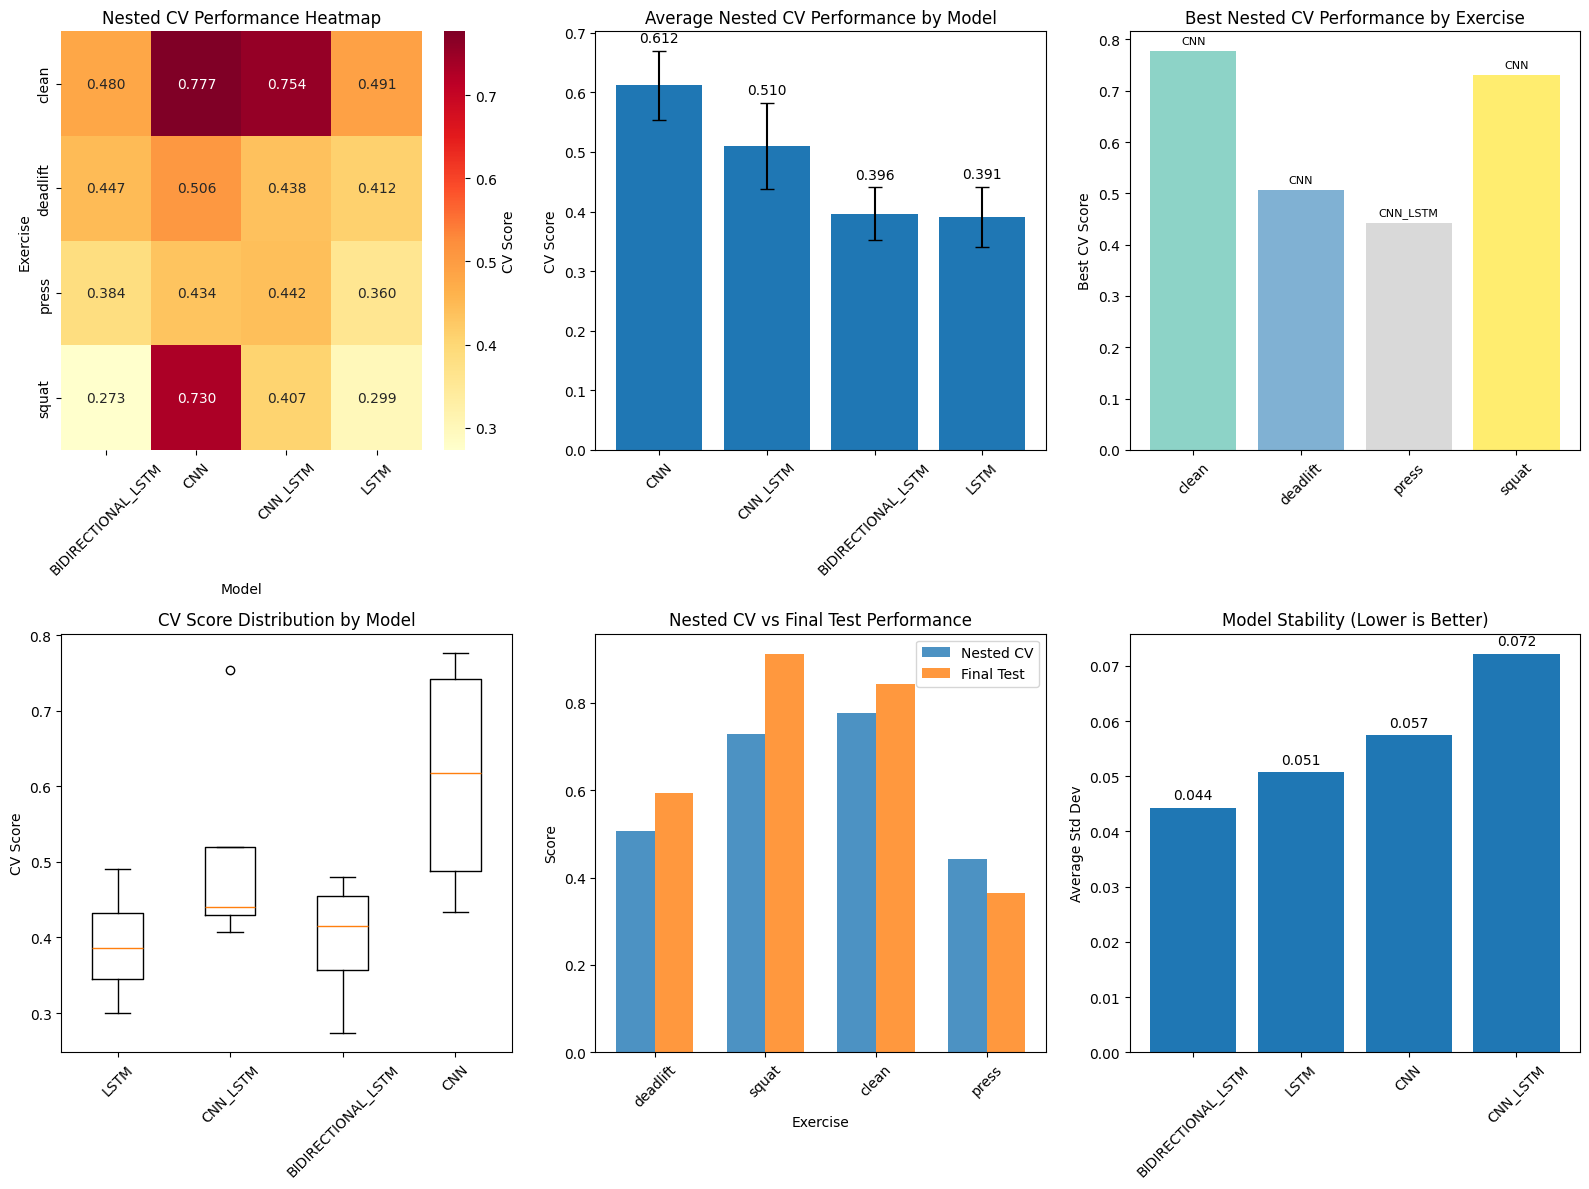

In [13]:
# ==================== 6단계: Nested CV 결과 시각화 및 분석 ====================
print("\n6단계: Nested CV 결과 시각화 및 분석")

# Nested CV 결과 요약
print("\n=== Nested Cross-Validation 결과 요약 ===")
nested_summary_results = []

for exercise_name, exercise_results in nested_cv_results.items():
    print(f"\n{exercise_name.upper()}:")
    for model_type, result in exercise_results.items():
        mean_score = result['mean_score']
        std_score = result['std_score']
        nested_summary_results.append({
            'Exercise': exercise_name,
            'Model': model_type.upper(),
            'Mean_CV_Score': mean_score,
            'Std_CV_Score': std_score,
            'CV_Score_Display': f"{mean_score:.4f} ± {std_score:.4f}"
        })
        print(f"  {model_type.upper()}: {mean_score:.4f} ± {std_score:.4f}")

# 결과 DataFrame 생성
nested_summary_df = pd.DataFrame(nested_summary_results)

# 시각화
plt.figure(figsize=(16, 12))

# 1. Nested CV 성능 히트맵
plt.subplot(2, 3, 1)
pivot_df = nested_summary_df.pivot(index='Exercise', columns='Model', values='Mean_CV_Score')
sns.heatmap(pivot_df, annot=True, fmt='.3f', cmap='YlOrRd', cbar_kws={'label': 'CV Score'})
plt.title('Nested CV Performance Heatmap')
plt.xticks(rotation=45)

# 2. 모델별 평균 성능 (에러바 포함)
plt.subplot(2, 3, 2)
model_stats = nested_summary_df.groupby('Model').agg({
    'Mean_CV_Score': 'mean',
    'Std_CV_Score': 'mean'
}).reset_index().sort_values('Mean_CV_Score', ascending=False)

bars = plt.bar(range(len(model_stats)), model_stats['Mean_CV_Score'],
               yerr=model_stats['Std_CV_Score'], capsize=5)
plt.xticks(range(len(model_stats)), model_stats['Model'], rotation=45)
plt.ylabel('CV Score')
plt.title('Average Nested CV Performance by Model')

# 값 표시
for i, (mean_val, std_val) in enumerate(zip(model_stats['Mean_CV_Score'], model_stats['Std_CV_Score'])):
    plt.text(i, mean_val + std_val + 0.01, f'{mean_val:.3f}', ha='center', va='bottom')

# 3. 운동별 최고 성능
plt.subplot(2, 3, 3)
best_models = nested_summary_df.loc[nested_summary_df.groupby('Exercise')['Mean_CV_Score'].idxmax()]
colors = plt.cm.Set3(np.linspace(0, 1, len(best_models)))

bars = plt.bar(range(len(best_models)), best_models['Mean_CV_Score'], color=colors)
plt.xticks(range(len(best_models)), best_models['Exercise'], rotation=45)
plt.ylabel('Best CV Score')
plt.title('Best Nested CV Performance by Exercise')

# 모델명 표시
for i, (_, row) in enumerate(best_models.iterrows()):
    plt.text(i, row['Mean_CV_Score'] + 0.01, row['Model'], ha='center', va='bottom', fontsize=8)

# 4. CV 점수 분포 박스플롯
plt.subplot(2, 3, 4)
cv_data = []
model_labels = []
for model in nested_summary_df['Model'].unique():
    model_scores = nested_summary_df[nested_summary_df['Model'] == model]['Mean_CV_Score'].values
    cv_data.append(model_scores)
    model_labels.append(model)

plt.boxplot(cv_data, labels=model_labels)
plt.xticks(rotation=45)
plt.ylabel('CV Score')
plt.title('CV Score Distribution by Model')

# 5. Nested CV vs Final Test 비교
plt.subplot(2, 3, 5)
comparison_data = []
for exercise_name in nested_cv_results.keys():
    # Nested CV 최고 점수
    best_model_type = max(nested_cv_results[exercise_name].keys(),
                         key=lambda x: nested_cv_results[exercise_name][x]['mean_score'])
    nested_score = nested_cv_results[exercise_name][best_model_type]['mean_score']

    # 최종 테스트 점수
    final_score = final_results[exercise_name]['accuracy']

    comparison_data.append({
        'Exercise': exercise_name,
        'Nested_CV': nested_score,
        'Final_Test': final_score
    })

comparison_df = pd.DataFrame(comparison_data)
x = np.arange(len(comparison_df))
width = 0.35

plt.bar(x - width/2, comparison_df['Nested_CV'], width, label='Nested CV', alpha=0.8)
plt.bar(x + width/2, comparison_df['Final_Test'], width, label='Final Test', alpha=0.8)

plt.xlabel('Exercise')
plt.ylabel('Score')
plt.title('Nested CV vs Final Test Performance')
plt.xticks(x, comparison_df['Exercise'], rotation=45)
plt.legend()

# 6. 표준편차 분석
plt.subplot(2, 3, 6)
std_analysis = nested_summary_df.groupby('Model')['Std_CV_Score'].mean().sort_values()
bars = plt.bar(range(len(std_analysis)), std_analysis.values)
plt.xticks(range(len(std_analysis)), std_analysis.index, rotation=45)
plt.ylabel('Average Std Dev')
plt.title('Model Stability (Lower is Better)')

# 값 표시
for i, val in enumerate(std_analysis.values):
    plt.text(i, val + 0.001, f'{val:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


7단계: 최고 성능 모델 선택 및 상세 분석

Nested CV 전체 최고 성능: clean - CNN (CV 점수: 0.7768 ± 0.0169)

각 운동별 Nested CV 최고 성능 모델:
deadlift: CNN (CV 점수: 0.5062 ± 0.0622)
squat: CNN (CV 점수: 0.7298 ± 0.0304)
clean: CNN (CV 점수: 0.7768 ± 0.0169)
press: CNN_LSTM (CV 점수: 0.4421 ± 0.0533)

deadlift - CNN 모델 상세 분석:


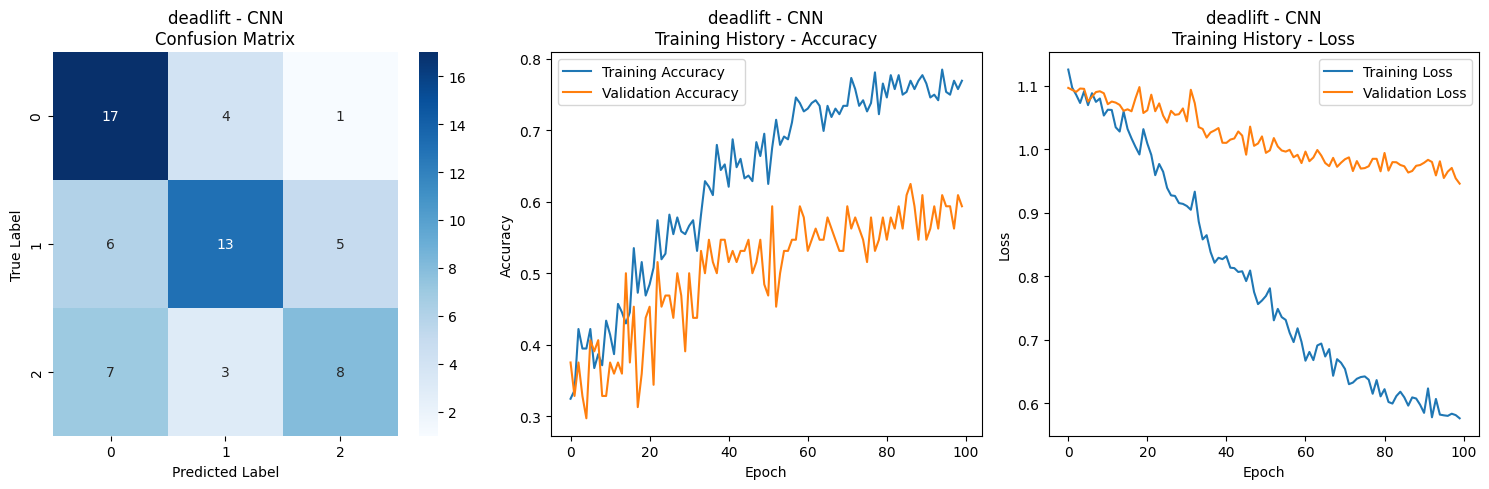


deadlift - CNN Classification Report:
                   precision    recall  f1-score   support

           Normal       0.57      0.77      0.65        22
        Hip Error       0.65      0.54      0.59        24
Arm Posture Error       0.57      0.44      0.50        18

         accuracy                           0.59        64
        macro avg       0.60      0.59      0.58        64
     weighted avg       0.60      0.59      0.59        64



In [14]:
# ==================== 7단계: 최고 성능 모델 선택 및 상세 분석 ====================
print("\n7단계: 최고 성능 모델 선택 및 상세 분석")

# Nested CV 기반 전체 최고 성능 모델 찾기
best_overall_nested = nested_summary_df.loc[nested_summary_df['Mean_CV_Score'].idxmax()]
print(f"\nNested CV 전체 최고 성능: {best_overall_nested['Exercise']} - {best_overall_nested['Model']} "
      f"(CV 점수: {best_overall_nested['CV_Score_Display']})")

# 각 운동별 최고 성능 모델
print("\n각 운동별 Nested CV 최고 성능 모델:")
for exercise in nested_summary_df['Exercise'].unique():
    exercise_best = nested_summary_df[nested_summary_df['Exercise'] == exercise].loc[
        nested_summary_df[nested_summary_df['Exercise'] == exercise]['Mean_CV_Score'].idxmax()
    ]
    print(f"{exercise}: {exercise_best['Model']} (CV 점수: {exercise_best['CV_Score_Display']})")

# 상세 분류 리포트 (첫 번째 운동 예시)
first_exercise = list(final_results.keys())[0]
first_best_result = final_results[first_exercise]

print(f"\n{first_exercise} - {first_best_result['model_name'].upper()} 모델 상세 분석:")

# 혼동 행렬과 학습 곡선
plt.figure(figsize=(15, 5))

# 혼동 행렬
plt.subplot(1, 3, 1)
cm = confusion_matrix(first_best_result['y_test'], first_best_result['y_pred'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'{first_exercise} - {first_best_result["model_name"].upper()}\nConfusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# 훈련 이력 - 정확도
plt.subplot(1, 3, 2)
history = first_best_result['history']
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title(f'{first_exercise} - {first_best_result["model_name"].upper()}\nTraining History - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 훈련 이력 - 손실
plt.subplot(1, 3, 3)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{first_exercise} - {first_best_result["model_name"].upper()}\nTraining History - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# 분류 리포트
print(f"\n{first_exercise} - {first_best_result['model_name'].upper()} Classification Report:")
target_names = [exercise_info[first_exercise]['labels'][i] for i in sorted(exercise_info[first_exercise]['labels'].keys())]
print(classification_report(first_best_result['y_test'], first_best_result['y_pred'], target_names=target_names))


=== DEADLIFT - CNN 모델 상세 분석 ===


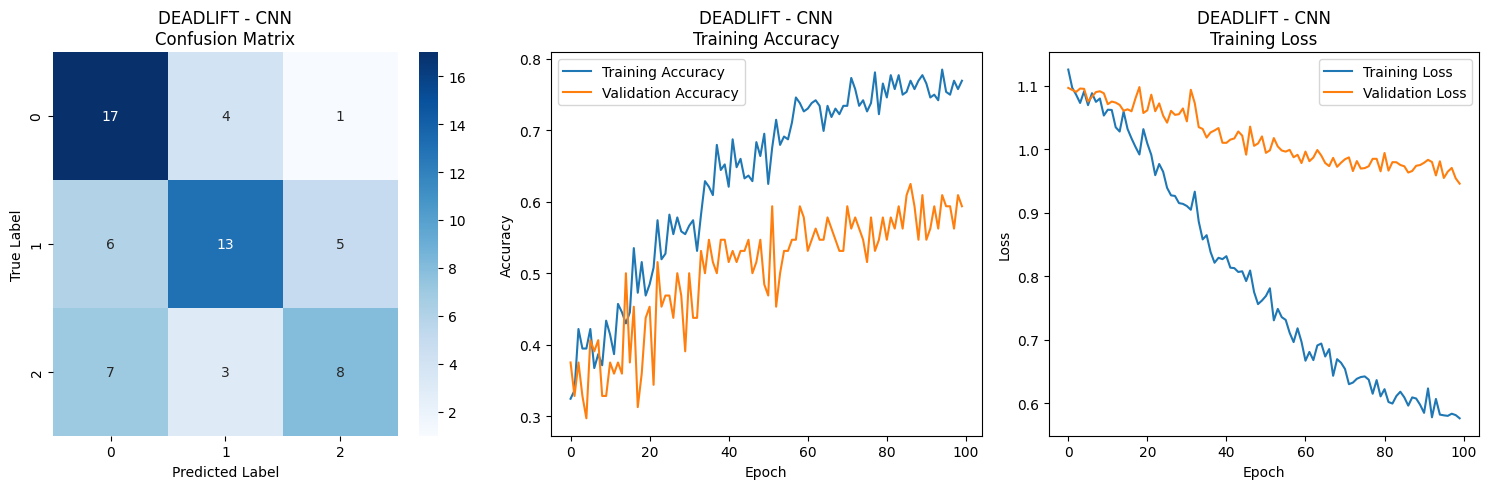


DEADLIFT - Classification Report:
                   precision    recall  f1-score   support

           Normal       0.57      0.77      0.65        22
        Hip Error       0.65      0.54      0.59        24
Arm Posture Error       0.57      0.44      0.50        18

         accuracy                           0.59        64
        macro avg       0.60      0.59      0.58        64
     weighted avg       0.60      0.59      0.59        64


DEADLIFT - 상세 통계 분석:

1. 클래스별 Odds Ratio 분석:
----------------------------------------

Normal:
  Odds Ratio: 7.5846
  p-value: 0.0006
  95% CI Lower: 2.3014
  95% CI Upper: 24.9959

Hip Error:
  Odds Ratio: 5.5714
  p-value: 0.0046
  95% CI Lower: 1.7738
  95% CI Upper: 17.4997

Arm Posture Error:
  Odds Ratio: 5.3333
  p-value: 0.0151
  95% CI Lower: 1.5050
  95% CI Upper: 18.8998

2. 통계적 검정 결과:
----------------------------------------

Normal:
  T-statistic (평균): 0.7106
  T-test p-value (최소): 0.0507
  Chi-square statistic: 10.6487
  Chi-squ

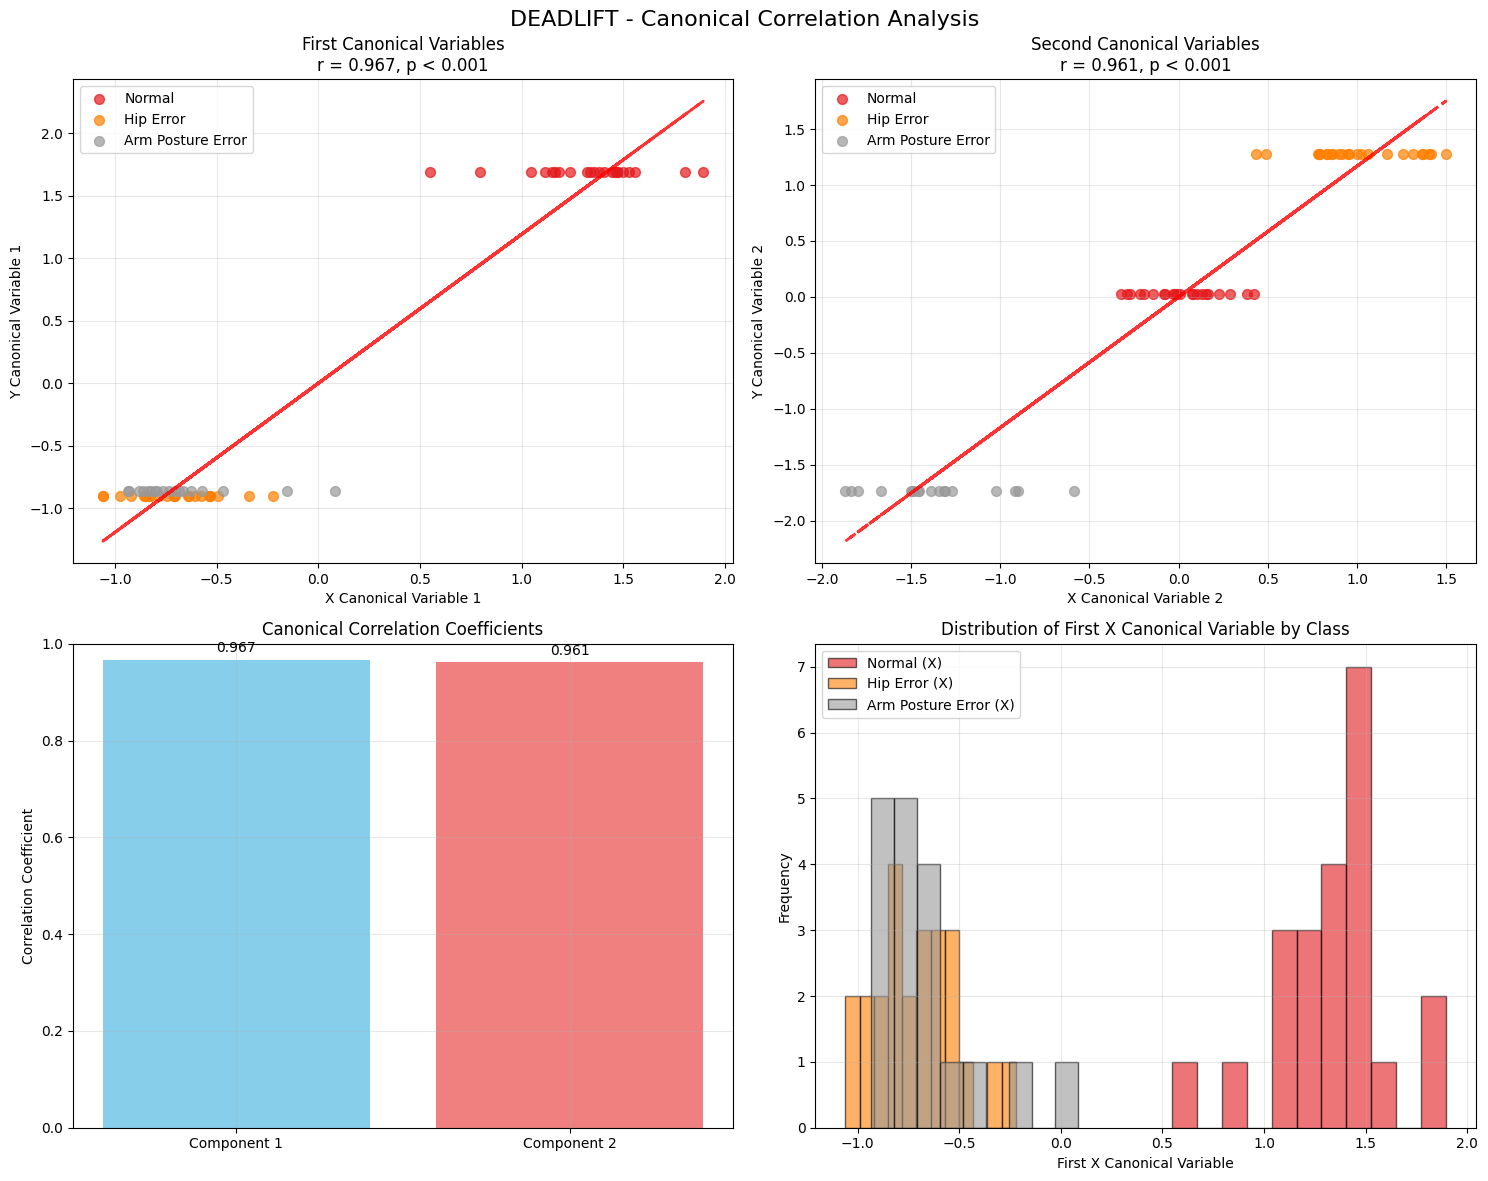

  정준상관계수들: ['0.9672', '0.9613']
  사용된 성분 수: 2
  최대 정준상관계수: 0.9672
  해석: 강한 정준상관관계 (r > 0.7)
  통계적 해석: 예측 모델과 실제 클래스 간 의미있는 관계

4. DEADLIFT 종합 통계 요약:
----------------------------------------
  전체 정확도: 0.5938
  최고 성능 클래스: Normal (0.7727)
  최저 성능 클래스: Arm Posture Error (0.4444)
  통계적으로 유의한 클래스들 (p < 0.05): Normal, Hip Error, Arm Posture Error


=== SQUAT - CNN 모델 상세 분석 ===


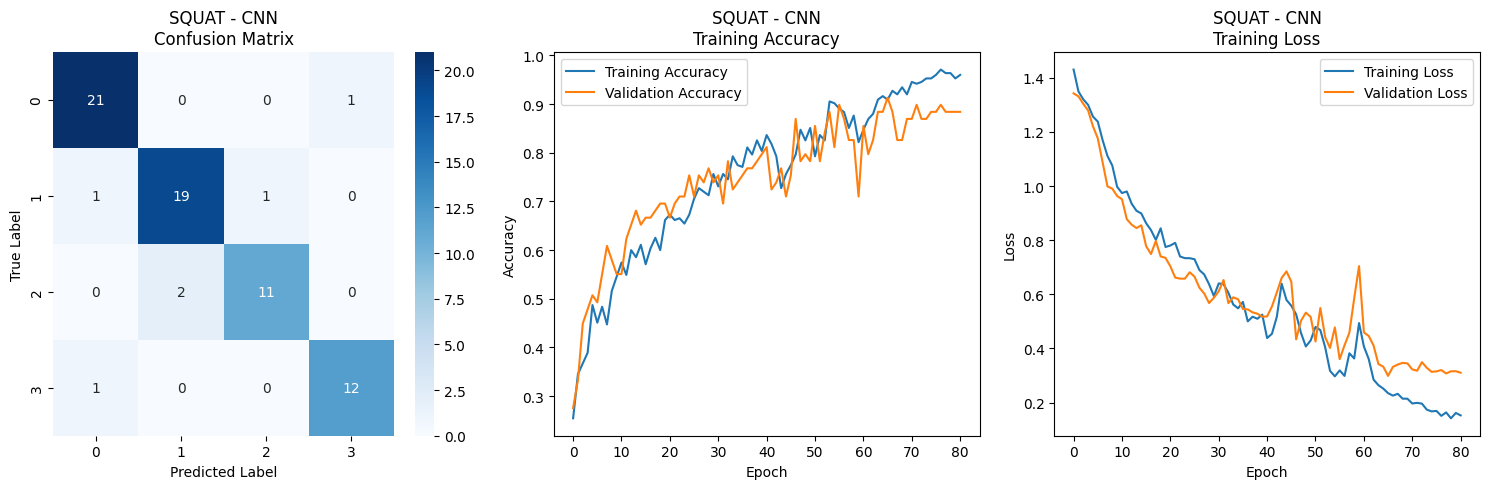


SQUAT - Classification Report:
                 precision    recall  f1-score   support

         Normal       0.91      0.95      0.93        22
      Hip Error       0.90      0.90      0.90        21
Butt Down Error       0.92      0.85      0.88        13
     Heel Error       0.92      0.92      0.92        13

       accuracy                           0.91        69
      macro avg       0.91      0.91      0.91        69
   weighted avg       0.91      0.91      0.91        69


SQUAT - 상세 통계 분석:

1. 클래스별 Odds Ratio 분석:
----------------------------------------

Normal:
  Odds Ratio: 472.5000
  p-value: 0.0000
  95% CI Lower: 40.5400
  95% CI Upper: 5507.0621

Hip Error:
  Odds Ratio: 218.5000
  p-value: 0.0000
  95% CI Lower: 28.6516
  95% CI Upper: 1666.3025

Butt Down Error:
  Odds Ratio: 302.5000
  p-value: 0.0000
  95% CI Lower: 25.1743
  95% CI Upper: 3634.9122

Heel Error:
  Odds Ratio: 660.0000
  p-value: 0.0000
  95% CI Lower: 38.5095
  95% CI Upper: 11311.4881

2. 통계적 

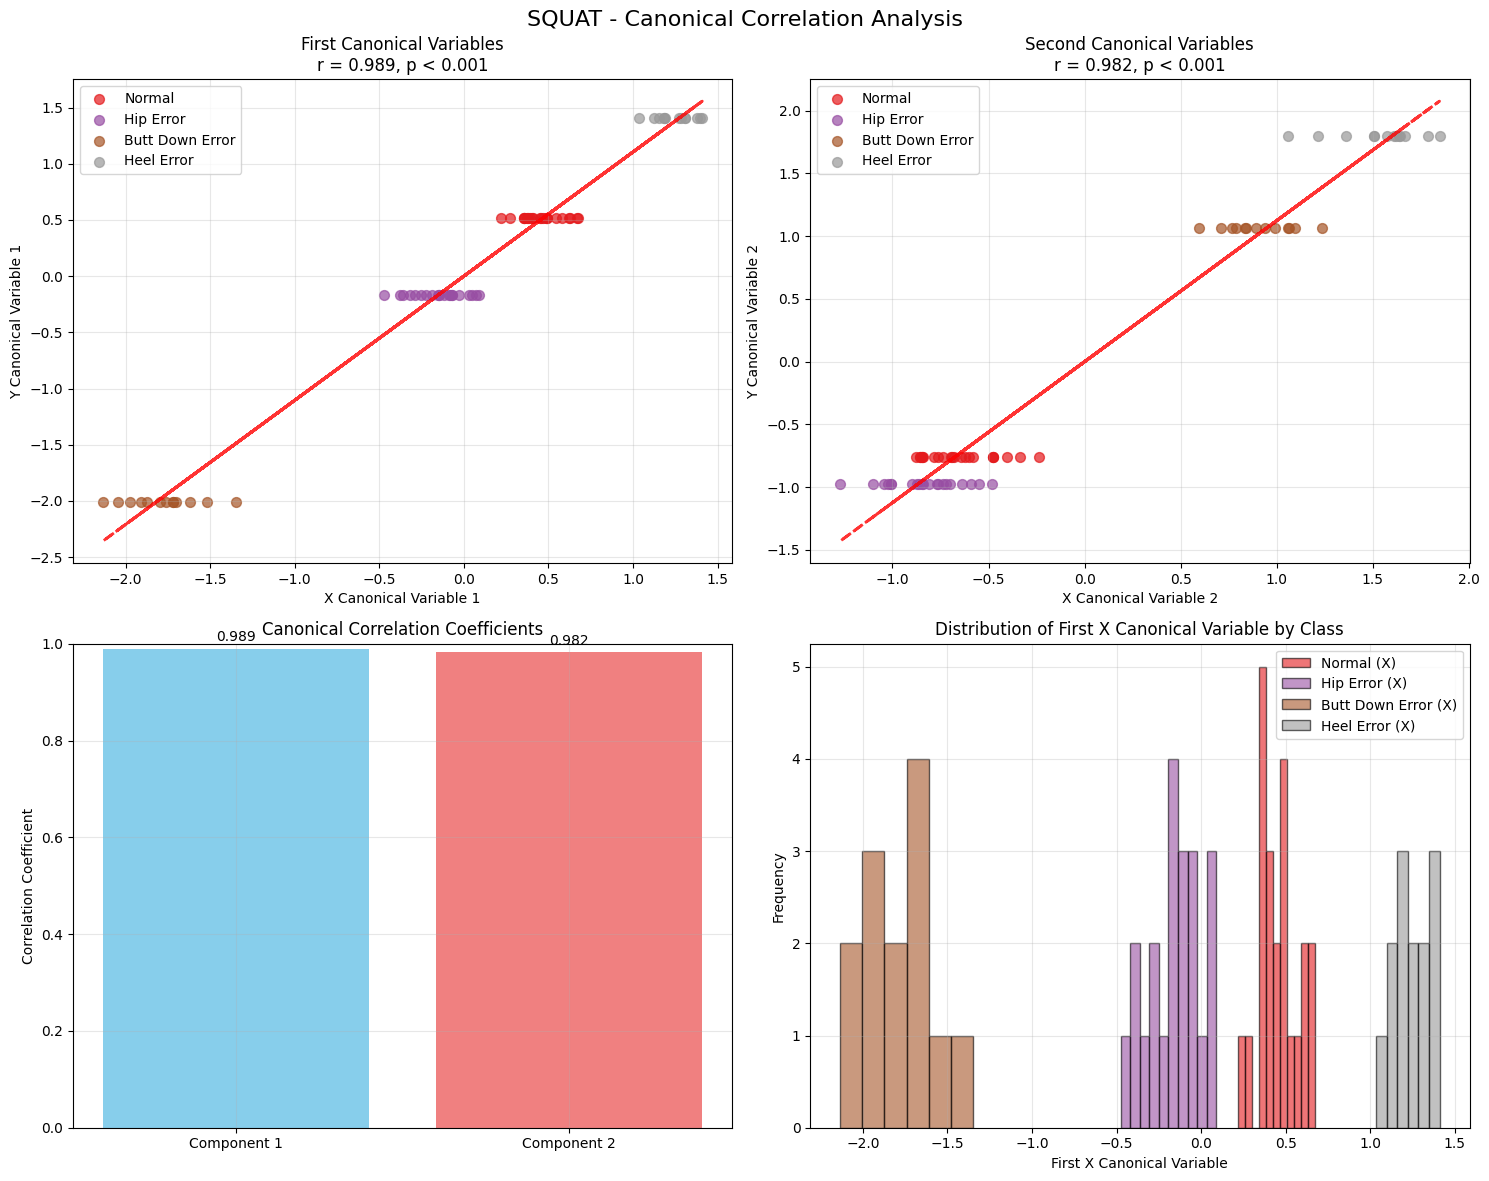

  정준상관계수들: ['0.9888', '0.9819']
  사용된 성분 수: 2
  최대 정준상관계수: 0.9888
  해석: 강한 정준상관관계 (r > 0.7)
  통계적 해석: 예측 모델과 실제 클래스 간 의미있는 관계

4. SQUAT 종합 통계 요약:
----------------------------------------
  전체 정확도: 0.9130
  최고 성능 클래스: Normal (0.9545)
  최저 성능 클래스: Butt Down Error (0.8462)
  통계적으로 유의한 클래스들 (p < 0.05): Normal, Hip Error, Butt Down Error, Heel Error


=== CLEAN - CNN 모델 상세 분석 ===


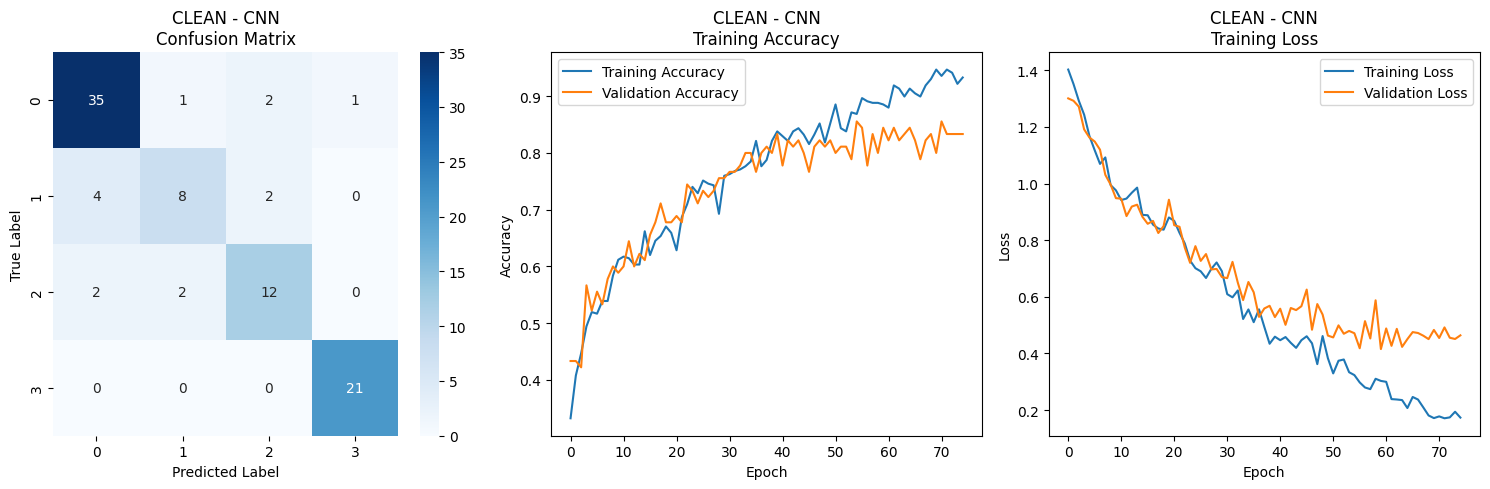


CLEAN - Classification Report:
                     precision    recall  f1-score   support

             Normal       0.85      0.90      0.88        39
          Hip Error       0.73      0.57      0.64        14
 Arm Movement Error       0.75      0.75      0.75        16
Full Movement Error       0.95      1.00      0.98        21

           accuracy                           0.84        90
          macro avg       0.82      0.80      0.81        90
       weighted avg       0.84      0.84      0.84        90


CLEAN - 상세 통계 분석:

1. 클래스별 Odds Ratio 분석:
----------------------------------------

Normal:
  Odds Ratio: 65.6250
  p-value: 0.0000
  95% CI Lower: 17.1824
  95% CI Upper: 250.6430

Hip Error:
  Odds Ratio: 32.4444
  p-value: 0.0000
  95% CI Lower: 6.7742
  95% CI Upper: 155.3894

Arm Movement Error:
  Odds Ratio: 52.5000
  p-value: 0.0000
  95% CI Lower: 11.5377
  95% CI Upper: 238.8910

Full Movement Error:
  Odds Ratio: inf
  p-value: 0.0000
  95% CI Lower: 0.0000
  95

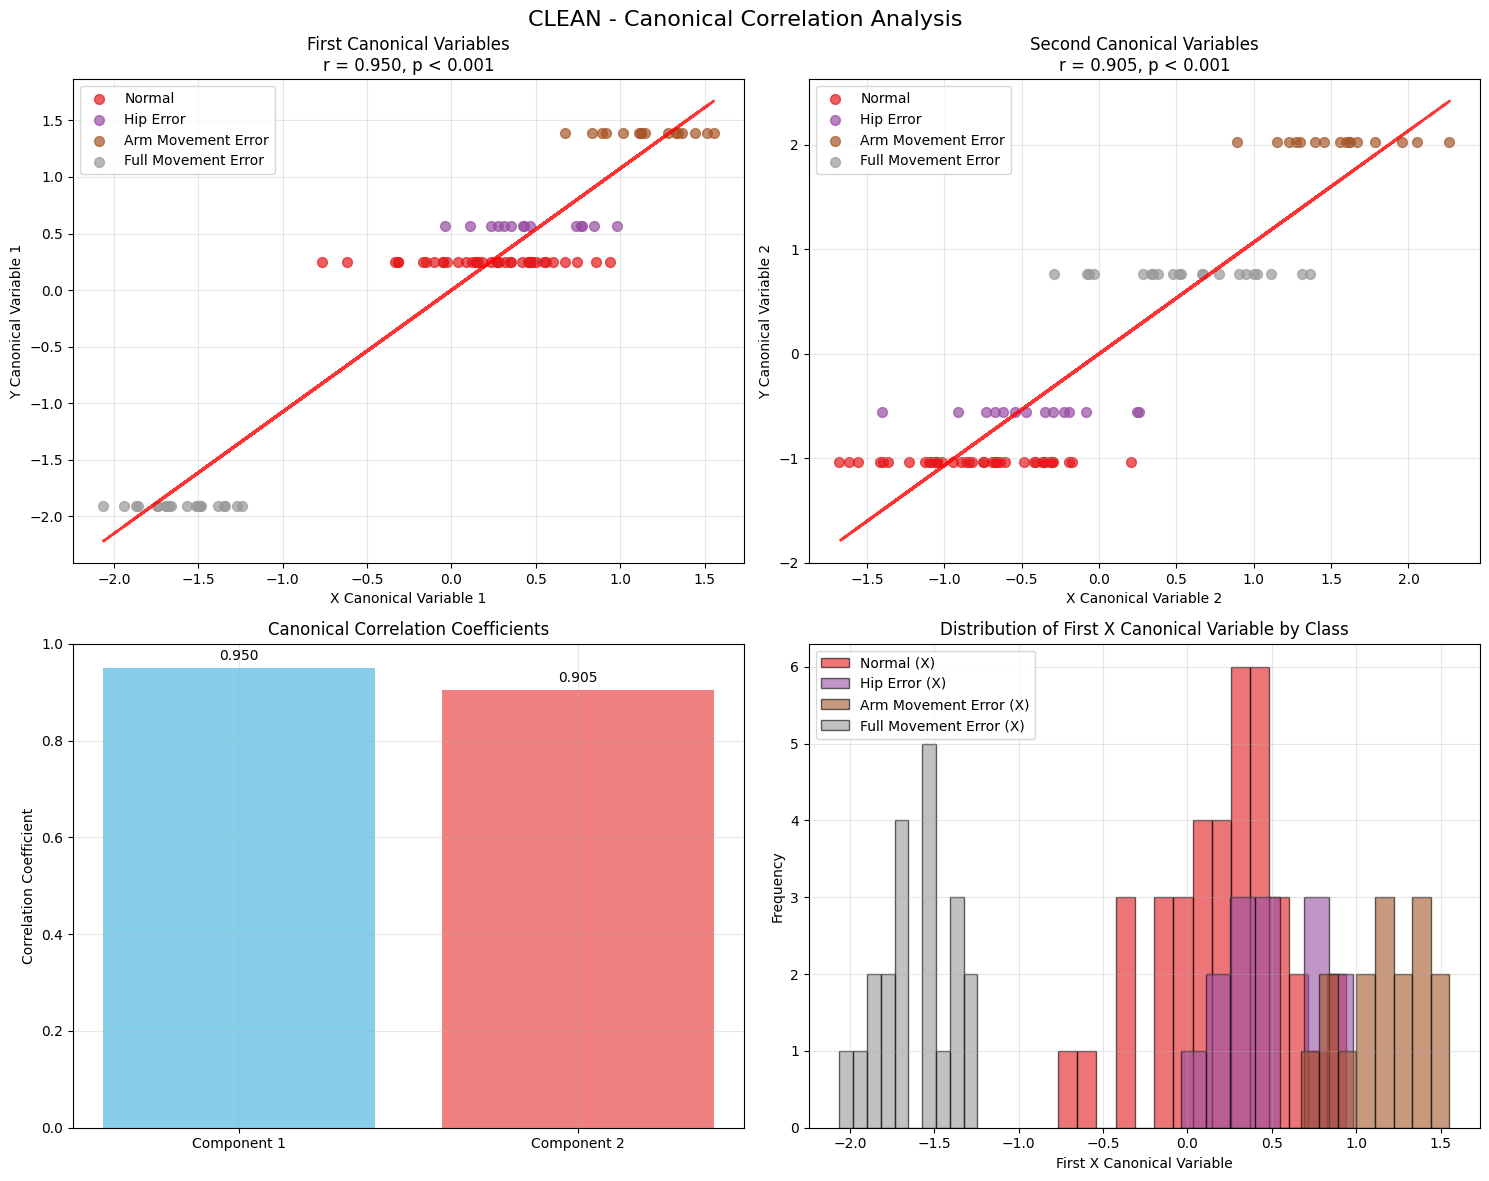

  정준상관계수들: ['0.9502', '0.9046']
  사용된 성분 수: 2
  최대 정준상관계수: 0.9502
  해석: 강한 정준상관관계 (r > 0.7)
  통계적 해석: 예측 모델과 실제 클래스 간 의미있는 관계

4. CLEAN 종합 통계 요약:
----------------------------------------
  전체 정확도: 0.8444
  최고 성능 클래스: Full Movement Error (1.0000)
  최저 성능 클래스: Hip Error (0.5714)
  통계적으로 유의한 클래스들 (p < 0.05): Normal, Hip Error, Arm Movement Error, Full Movement Error


=== PRESS - CNN_LSTM 모델 상세 분석 ===


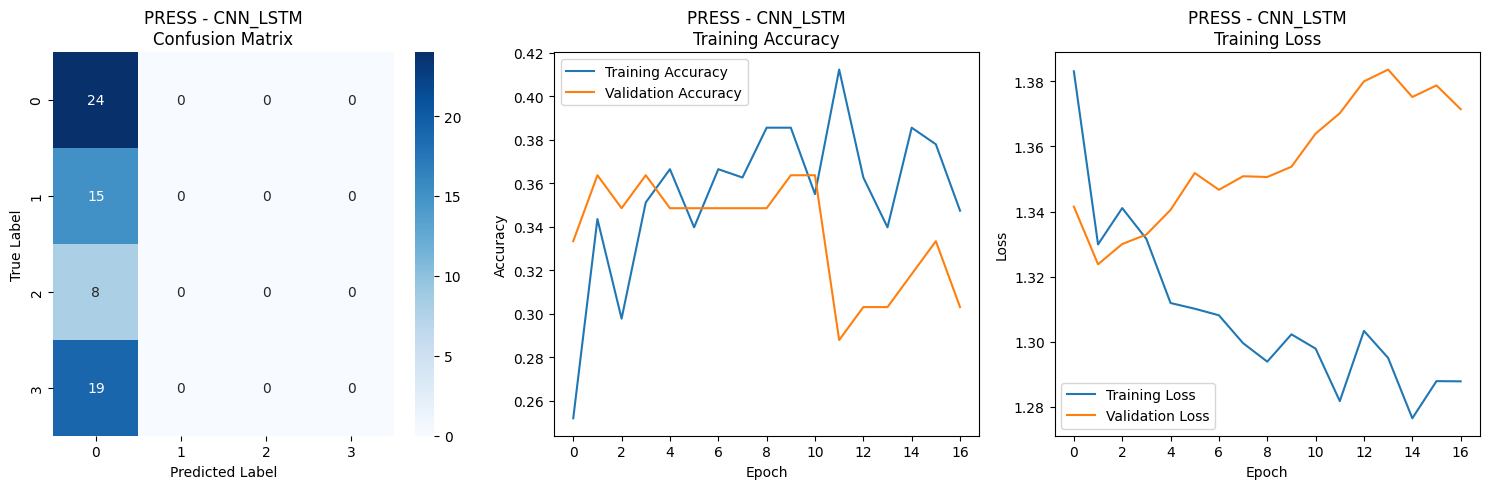


PRESS - Classification Report:
                               precision    recall  f1-score   support

                       Normal       0.36      1.00      0.53        24
               Overhead Error       0.00      0.00      0.00        15
           Arm Movement Error       0.00      0.00      0.00         8
Elbow-Shoulder Inactive Error       0.00      0.00      0.00        19

                     accuracy                           0.36        66
                    macro avg       0.09      0.25      0.13        66
                 weighted avg       0.13      0.36      0.19        66


PRESS - 상세 통계 분석:

1. 클래스별 Odds Ratio 분석:
----------------------------------------

Normal:
  Odds Ratio: inf
  p-value: 1.0000
  95% CI Lower: 0.0000
  95% CI Upper: inf

Overhead Error:
  Odds Ratio: 0.0000
  p-value: 1.0000
  95% CI Lower: 0.0000
  95% CI Upper: inf

Arm Movement Error:
  Odds Ratio: 0.0000
  p-value: 1.0000
  95% CI Lower: 0.0000
  95% CI Upper: inf

Elbow-Shoulder Inactiv

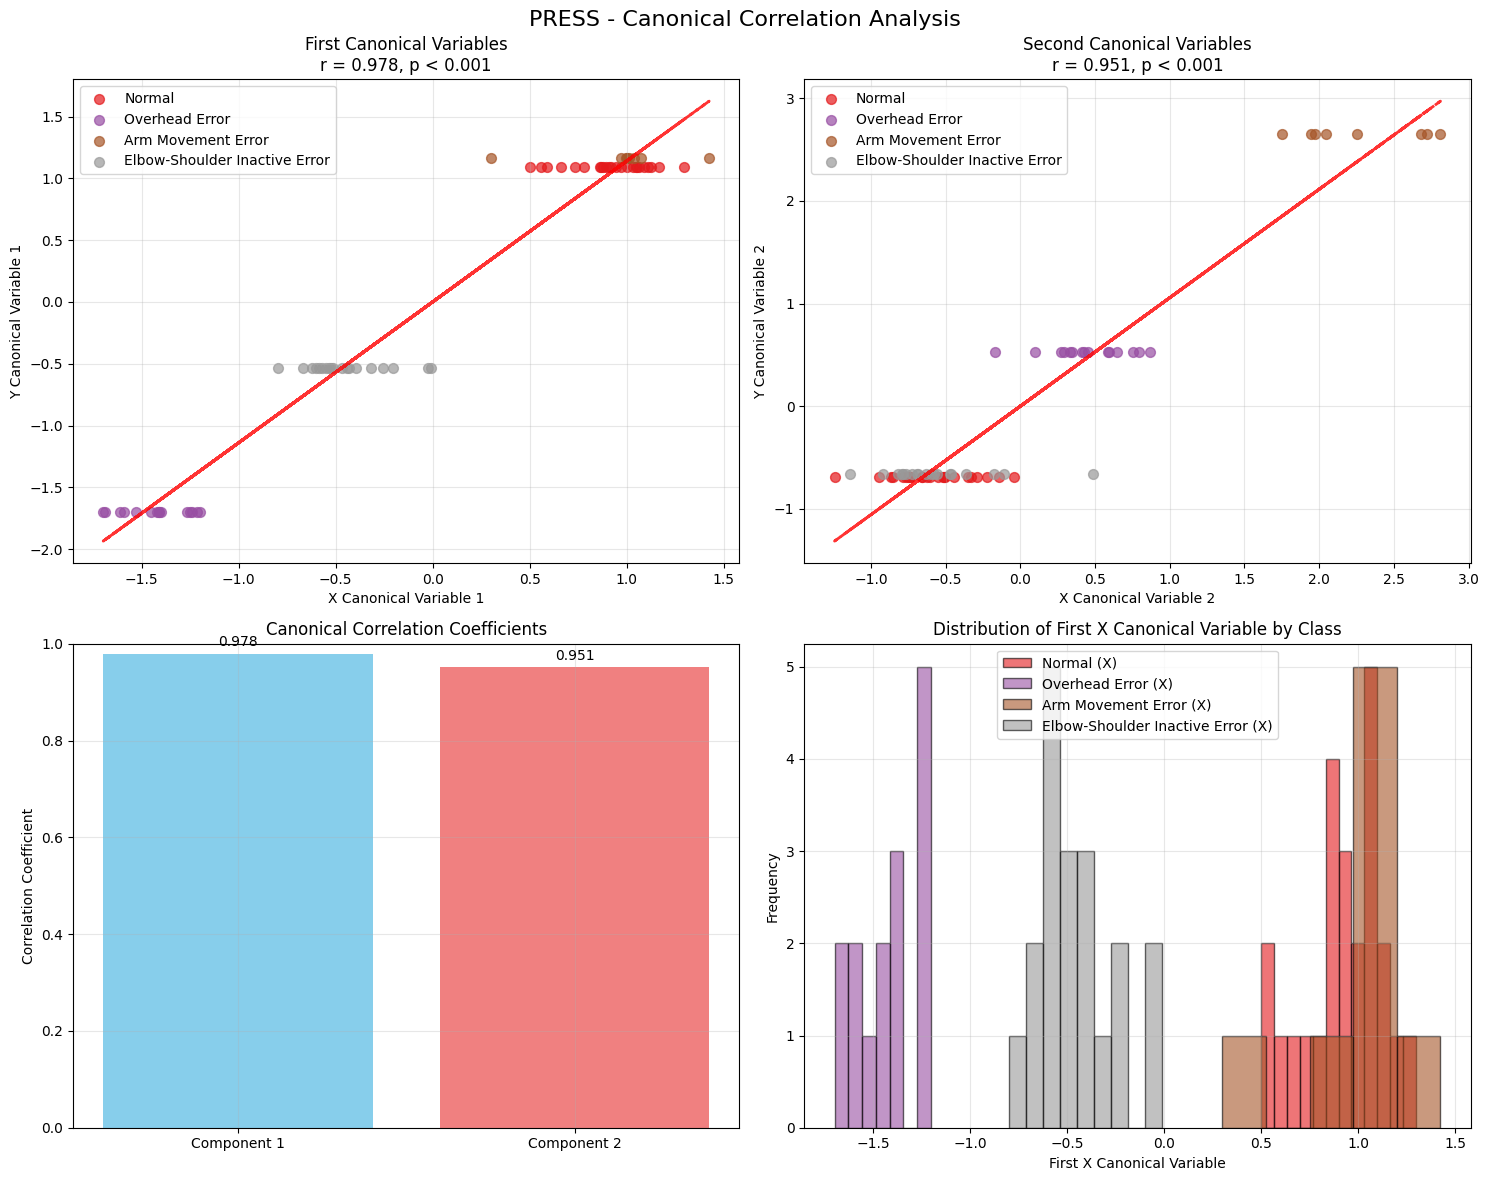

  정준상관계수들: ['0.9783', '0.9509']
  사용된 성분 수: 2
  최대 정준상관계수: 0.9783
  해석: 강한 정준상관관계 (r > 0.7)
  통계적 해석: 예측 모델과 실제 클래스 간 의미있는 관계

4. PRESS 종합 통계 요약:
----------------------------------------
  전체 정확도: 0.3636
  최고 성능 클래스: Normal (1.0000)
  최저 성능 클래스: Overhead Error (0.0000)
  통계적으로 유의한 클래스: 없음



In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency, ttest_ind, linregress
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

def calculate_odds_ratio(cm, class_idx):
    tp = cm[class_idx, class_idx]
    fp = np.sum(cm[:, class_idx]) - tp
    fn = np.sum(cm[class_idx, :]) - tp
    tn = np.sum(cm) - tp - fp - fn

    # Odds ratio 계산
    if (fp == 0 or tn == 0):
        odds_ratio = float('inf') if (fn == 0 or tp > 0) else 0
        p_value = 1.0
        ci_lower, ci_upper = 0, float('inf')
    else:
        odds_ratio = (tp * tn) / (fp * fn) if (fp * fn) != 0 else float('inf')

        # p-value 계산
        _, p_value = stats.fisher_exact([[tp, fp], [fn, tn]])

        # 95% 신뢰구간 계산
        log_or = np.log(odds_ratio) if odds_ratio > 0 and odds_ratio != float('inf') else 0
        se_log_or = np.sqrt(1/tp + 1/fp + 1/fn + 1/tn) if all([tp, fp, fn, tn]) else float('inf')

        if se_log_or != float('inf'):
            ci_lower = np.exp(log_or - 1.96 * se_log_or)
            ci_upper = np.exp(log_or + 1.96 * se_log_or)
        else:
            ci_lower, ci_upper = 0, float('inf')

    return {
        'odds_ratio': odds_ratio,
        'p_value': p_value,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper
    }

def perform_statistical_tests(X_test, y_test, y_pred, class_names):
    results = {}
    n_classes = len(class_names)

    for i, class_name in enumerate(class_names):
        true_binary = (y_test == i).astype(int)
        pred_binary = (y_pred == i).astype(int)

        # T-test
        if X_test.shape[1] > 1:
            t_stats = []
            t_pvalues = []

            for feature_idx in range(X_test.shape[1]):
                class_data = X_test[true_binary == 1, feature_idx]
                other_data = X_test[true_binary == 0, feature_idx]

                if len(class_data) > 1 and len(other_data) > 1:
                    t_stat, t_pval = ttest_ind(class_data, other_data)
                    t_stats.append(t_stat)
                    t_pvalues.append(t_pval)
                else:
                    t_stats.append(0)
                    t_pvalues.append(1.0)

            avg_t_stat = np.mean(np.abs(t_stats))
            min_t_pval = np.min(t_pvalues)
        else:
            avg_t_stat = 0
            min_t_pval = 1.0

        # Chi-square test
        contingency_table = pd.crosstab(true_binary, pred_binary)

        if contingency_table.shape == (2, 2):
            chi2_stat, chi2_pval, _, _ = chi2_contingency(contingency_table)
        else:
            chi2_stat, chi2_pval = 0, 1.0

        results[class_name] = {
            't_statistic': avg_t_stat,
            't_p_value': min_t_pval,
            'chi2_statistic': chi2_stat,
            'chi2_p_value': chi2_pval
        }

    return results

def perform_enhanced_cca_analysis(X_test, y_test, class_names, exercise_name):
    """
    Enhanced Canonical Correlation Analysis with proper handling of multidimensional data
    """
    try:
        # X_test가 3차원인 경우 (samples, time_steps, features) -> 2차원으로 변환
        if len(X_test.shape) == 3:
            # 시계열 데이터를 평탄화: (samples, time_steps * features)
            X_flattened = X_test.reshape(X_test.shape[0], -1)
            print(f"  3차원 데이터를 2차원으로 변환: {X_test.shape} -> {X_flattened.shape}")
        else:
            X_flattened = X_test

        # y를 원-핫 인코딩
        n_classes = len(np.unique(y_test))
        Y_onehot = np.eye(n_classes)[y_test]

        # 차원 확인 및 조정
        print(f"  X 형태: {X_flattened.shape}, Y 형태: {Y_onehot.shape}")

        # 데이터가 너무 클 경우 PCA로 차원 축소
        max_features = 50  # 최대 특성 수 제한
        if X_flattened.shape[1] > max_features:
            from sklearn.decomposition import PCA
            pca = PCA(n_components=max_features)
            X_reduced = pca.fit_transform(X_flattened)
            print(f"  PCA로 차원 축소: {X_flattened.shape[1]} -> {X_reduced.shape[1]} features")
            print(f"  설명된 분산 비율: {pca.explained_variance_ratio_.sum():.3f}")
        else:
            X_reduced = X_flattened

        # 데이터 표준화
        scaler_X = StandardScaler()
        scaler_Y = StandardScaler()
        X_scaled = scaler_X.fit_transform(X_reduced)
        Y_scaled = scaler_Y.fit_transform(Y_onehot)

        # CCA 수행
        n_comp = min(2, X_scaled.shape[1], Y_scaled.shape[1], X_scaled.shape[0] - 1)
        print(f"  CCA 성분 수: {n_comp}")

        if n_comp <= 0:
            raise ValueError("CCA를 수행하기에 충분한 성분이 없습니다.")

        cca = CCA(n_components=n_comp)
        X_c, Y_c = cca.fit_transform(X_scaled, Y_scaled)

        # 정준상관계수 계산
        canonical_correlations = []
        for i in range(n_comp):
            corr = np.corrcoef(X_c[:, i], Y_c[:, i])[0, 1]
            canonical_correlations.append(abs(corr))

        # 시각화
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle(f'{exercise_name.upper()} - Canonical Correlation Analysis', fontsize=16)

        # 1. CCA Scatter Plot (첫 번째 정준변수)
        if n_comp >= 1:
            ax1 = axes[0, 0]
            colors = plt.cm.Set1(np.linspace(0, 1, n_classes))

            for i, class_name in enumerate(class_names):
                mask = y_test == i
                if np.sum(mask) > 0:  # 클래스에 데이터가 있는지 확인
                    ax1.scatter(X_c[mask, 0], Y_c[mask, 0],
                               c=[colors[i]], label=class_name, alpha=0.7, s=50)

            # 회귀선 추가
            if len(X_c[:, 0]) > 1:  # 데이터가 충분한지 확인
                slope, intercept, r_value, p_value, std_err = linregress(X_c[:, 0], Y_c[:, 0])
                line = slope * X_c[:, 0] + intercept
                ax1.plot(X_c[:, 0], line, 'r--', alpha=0.8, linewidth=2)

                p_str = 'p < 0.001' if p_value < 0.001 else f'p = {p_value:.3f}'
                ax1.set_title(f'First Canonical Variables\nr = {canonical_correlations[0]:.3f}, {p_str}')
            else:
                ax1.set_title(f'First Canonical Variables\nr = {canonical_correlations[0]:.3f}')

            ax1.set_xlabel('X Canonical Variable 1')
            ax1.set_ylabel('Y Canonical Variable 1')
            ax1.legend()
            ax1.grid(True, alpha=0.3)

        # 2. CCA Scatter Plot (두 번째 정준변수) - 가능한 경우
        if n_comp >= 2:
            ax2 = axes[0, 1]
            for i, class_name in enumerate(class_names):
                mask = y_test == i
                if np.sum(mask) > 0:
                    ax2.scatter(X_c[mask, 1], Y_c[mask, 1],
                               c=[colors[i]], label=class_name, alpha=0.7, s=50)

            # 회귀선 추가
            if len(X_c[:, 1]) > 1:
                slope, intercept, r_value, p_value, std_err = linregress(X_c[:, 1], Y_c[:, 1])
                line = slope * X_c[:, 1] + intercept
                ax2.plot(X_c[:, 1], line, 'r--', alpha=0.8, linewidth=2)

                p_str = 'p < 0.001' if p_value < 0.001 else f'p = {p_value:.3f}'
                ax2.set_title(f'Second Canonical Variables\nr = {canonical_correlations[1]:.3f}, {p_str}')
            else:
                ax2.set_title(f'Second Canonical Variables\nr = {canonical_correlations[1]:.3f}')

            ax2.set_xlabel('X Canonical Variable 2')
            ax2.set_ylabel('Y Canonical Variable 2')
            ax2.legend()
            ax2.grid(True, alpha=0.3)
        else:
            axes[0, 1].text(0.5, 0.5, 'Not enough components\nfor second canonical variable',
                           ha='center', va='center', transform=axes[0, 1].transAxes)
            axes[0, 1].set_title('Second Canonical Variables')

        # 3. 정준상관계수 바 차트
        ax3 = axes[1, 0]
        component_names = [f'Component {i+1}' for i in range(len(canonical_correlations))]
        bars = ax3.bar(component_names, canonical_correlations,
                      color=['skyblue', 'lightcoral'][:len(canonical_correlations)])
        ax3.set_title('Canonical Correlation Coefficients')
        ax3.set_ylabel('Correlation Coefficient')
        ax3.set_ylim(0, 1)

        # 값 표시
        for bar, corr in zip(bars, canonical_correlations):
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{corr:.3f}', ha='center', va='bottom')
        ax3.grid(True, alpha=0.3)

        # 4. 클래스별 정준변수 분포 (첫 번째 정준변수)
        ax4 = axes[1, 1]
        if n_comp >= 1:
            for i, class_name in enumerate(class_names):
                mask = y_test == i
                if np.sum(mask) > 0:
                    ax4.hist(X_c[mask, 0], alpha=0.6, label=f'{class_name} (X)',
                            bins=min(15, max(5, np.sum(mask)//2)),
                            color=colors[i], edgecolor='black')

            ax4.set_title('Distribution of First X Canonical Variable by Class')
            ax4.set_xlabel('First X Canonical Variable')
            ax4.set_ylabel('Frequency')
            ax4.legend()
            ax4.grid(True, alpha=0.3)
        else:
            ax4.text(0.5, 0.5, 'No canonical variables available',
                    ha='center', va='center', transform=ax4.transAxes)

        plt.tight_layout()
        plt.show()

        # 결과 반환
        return {
            'canonical_correlations': canonical_correlations,
            'n_components': n_comp,
            'X_canonical': X_c,
            'Y_canonical': Y_c,
            'original_shape': X_test.shape,
            'flattened_shape': X_flattened.shape if 'X_flattened' in locals() else None,
            'reduced_shape': X_reduced.shape if 'X_reduced' in locals() else None,
            'loadings_X': cca.x_loadings_ if hasattr(cca, 'x_loadings_') else None,
            'loadings_Y': cca.y_loadings_ if hasattr(cca, 'y_loadings_') else None
        }

    except Exception as e:
        print(f"CCA 분석 중 오류 발생: {str(e)}")
        import traceback
        print(f"상세 오류: {traceback.format_exc()}")
        return {
            'canonical_correlations': [0],
            'n_components': 0,
            'error': str(e)
        }

# 모든 운동 클래스에 대해 시각화 및 통계 분석
for exercise_name in final_results.keys():
    result = final_results[exercise_name]
    history = result['history']
    model_name = result['model_name'].upper()

    print(f"\n=== {exercise_name.upper()} - {model_name} 모델 상세 분석 ===")

    # 기존 시각화
    plt.figure(figsize=(15, 5))

    # 혼동 행렬
    plt.subplot(1, 3, 1)
    cm = confusion_matrix(result['y_test'], result['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{exercise_name.upper()} - {model_name}\nConfusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    # 훈련 이력 - 정확도
    plt.subplot(1, 3, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{exercise_name.upper()} - {model_name}\nTraining Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # 훈련 이력 - 손실
    plt.subplot(1, 3, 3)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{exercise_name.upper()} - {model_name}\nTraining Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # 분류 리포트
    print(f"\n{exercise_name.upper()} - Classification Report:")
    target_names = [exercise_info[exercise_name]['labels'][i] for i in sorted(exercise_info[exercise_name]['labels'].keys())]
    print(classification_report(result['y_test'], result['y_pred'], target_names=target_names))

    # === 추가된 통계 분석 ===
    print(f"\n{exercise_name.upper()} - 상세 통계 분석:")
    print("="*60)

    # 1. 클래스별 Odds Ratio 분석
    print("\n1. 클래스별 Odds Ratio 분석:")
    print("-" * 40)

    odds_ratio_results = {}
    for class_idx, class_name in enumerate(target_names):
        or_stats = calculate_odds_ratio(cm, class_idx)
        odds_ratio_results[class_name] = or_stats

        print(f"\n{class_name}:")
        print(f"  Odds Ratio: {or_stats['odds_ratio']:.4f}")
        print(f"  p-value: {or_stats['p_value']:.4f}")
        print(f"  95% CI Lower: {or_stats['ci_lower']:.4f}")
        print(f"  95% CI Upper: {or_stats['ci_upper']:.4f}")

    # 2. 통계적 검정 (T-test, Chi-square)
    print(f"\n2. 통계적 검정 결과:")
    print("-" * 40)

    if 'X_test' in result:  # X_test 데이터가 있는 경우
        stat_tests = perform_statistical_tests(
            result['X_test'], result['y_test'], result['y_pred'], target_names
        )

        for class_name, stats_result in stat_tests.items():
            print(f"\n{class_name}:")
            print(f"  T-statistic (평균): {stats_result['t_statistic']:.4f}")
            print(f"  T-test p-value (최소): {stats_result['t_p_value']:.4f}")
            print(f"  Chi-square statistic: {stats_result['chi2_statistic']:.4f}")
            print(f"  Chi-square p-value: {stats_result['chi2_p_value']:.4f}")
    else:
        print("  X_test 데이터가 없어 통계적 검정을 수행할 수 없습니다.")

    # 3. Enhanced Canonical Correlation Analysis (CCA)
    print(f"\n3. Enhanced Canonical Correlation Analysis (CCA):")
    print("-" * 40)

    if 'X_test' in result:
        try:
            # 수정된 함수 호출 (동일하지만 내부 로직이 개선됨)
            cca_results = perform_enhanced_cca_analysis(
                result['X_test'], result['y_test'], target_names, exercise_name
            )

            if 'error' not in cca_results:
                print(f"  정준상관계수들: {[f'{corr:.4f}' for corr in cca_results['canonical_correlations']]}")
                print(f"  사용된 성분 수: {cca_results['n_components']}")

                max_corr = max(cca_results['canonical_correlations'])
                print(f"  최대 정준상관계수: {max_corr:.4f}")

                if max_corr > 0.7:
                    print("  해석: 강한 정준상관관계 (r > 0.7)")
                elif max_corr > 0.5:
                    print("  해석: 중간 정준상관관계 (0.5 < r ≤ 0.7)")
                elif max_corr > 0.3:
                    print("  해석: 약한 정준상관관계 (0.3 < r ≤ 0.5)")
                else:
                    print("  해석: 매우 약한 정준상관관계 (r ≤ 0.3)")

                # 통계적 유의성 평가
                if max_corr > 0.5:
                    print("  통계적 해석: 예측 모델과 실제 클래스 간 의미있는 관계")
                else:
                    print("  통계적 해석: 예측 모델과 실제 클래스 간 관계가 약함")
            else:
                print(f"  CCA 분석 오류: {cca_results['error']}")

        except Exception as e:
            print(f"  CCA 수행 중 예외 발생: {str(e)}")
    else:
        print("  X_test 데이터가 없어 CCA 분석을 수행할 수 없습니다.")

    # 4. 종합 요약
    print(f"\n4. {exercise_name.upper()} 종합 통계 요약:")
    print("-" * 40)

    # 전체 정확도
    overall_accuracy = accuracy_score(result['y_test'], result['y_pred'])
    print(f"  전체 정확도: {overall_accuracy:.4f}")

    # 가장 성능이 좋은/나쁜 클래스
    class_accuracies = {}
    for i, class_name in enumerate(target_names):
        class_mask = (result['y_test'] == i)
        if np.sum(class_mask) > 0:
            class_acc = np.sum((result['y_pred'][class_mask] == i)) / np.sum(class_mask)
            class_accuracies[class_name] = class_acc

    if class_accuracies:
        best_class = max(class_accuracies, key=class_accuracies.get)
        worst_class = min(class_accuracies, key=class_accuracies.get)

        print(f"  최고 성능 클래스: {best_class} ({class_accuracies[best_class]:.4f})")
        print(f"  최저 성능 클래스: {worst_class} ({class_accuracies[worst_class]:.4f})")

    # 통계적 유의성 요약
    significant_classes = []
    if 'X_test' in result:
        for class_name in target_names:
            if class_name in odds_ratio_results and odds_ratio_results[class_name]['p_value'] < 0.05:
                significant_classes.append(class_name)

    if significant_classes:
        print(f"  통계적으로 유의한 클래스들 (p < 0.05): {', '.join(significant_classes)}")
    else:
        print(f"  통계적으로 유의한 클래스: 없음")

    print("\n" + "="*80)

In [10]:
# ==================== 8단계: 실시간 예측을 위한 함수 ====================
print("\n8단계: 실시간 예측 함수 구현")

def predict_realtime(model, scaler, new_session_data, sequence_length):
    """실시간 예측 함수"""
    # 좌표 컬럼만 선택
    coord_columns = [col for col in new_session_data.columns if col not in ['crossfit_label', 'session_id']]

    # 표준화
    coords_scaled = scaler.transform(new_session_data[coord_columns])

    # 시퀀스 길이 조정
    if len(coords_scaled) >= sequence_length:
        coords_scaled = coords_scaled[-sequence_length:]  # 최근 프레임 사용
    else:
        # 패딩
        padding = np.tile(coords_scaled[0], (sequence_length - len(coords_scaled), 1))
        coords_scaled = np.vstack([padding, coords_scaled])

    # 배치 차원 추가
    coords_scaled = coords_scaled.reshape(1, sequence_length, -1)

    # 예측
    prediction = model.predict(coords_scaled)
    predicted_class = np.argmax(prediction)
    confidence = np.max(prediction)

    return predicted_class, confidence

def sliding_window_predict(model, scaler, session_data, sequence_length, window_step=10):
    """슬라이딩 윈도우를 사용한 실시간 예측"""
    coord_columns = [col for col in session_data.columns if col not in ['crossfit_label', 'session_id']]
    coords_scaled = scaler.transform(session_data[coord_columns])

    predictions = []
    confidences = []

    # 슬라이딩 윈도우로 예측
    for start_idx in range(0, len(coords_scaled) - sequence_length + 1, window_step):
        end_idx = start_idx + sequence_length
        window_data = coords_scaled[start_idx:end_idx]

        # 배치 차원 추가
        window_data = window_data.reshape(1, sequence_length, -1)

        # 예측
        prediction = model.predict(window_data)
        predicted_class = np.argmax(prediction)
        confidence = np.max(prediction)

        predictions.append(predicted_class)
        confidences.append(confidence)

    # 최종 예측 (가장 자주 예측된 클래스)
    final_prediction = max(set(predictions), key=predictions.count)
    avg_confidence = np.mean(confidences)

    return final_prediction, avg_confidence, predictions, confidences

# 예시 사용법
print("\n실시간 예측 함수 사용 예시:")
print("# 단일 예측")
print("predicted_class, confidence = predict_realtime(model, scaler, new_session_data, sequence_length)")
print("\n# 슬라이딩 윈도우 예측 (더 안정적)")
print("final_pred, avg_conf, all_preds, all_confs = sliding_window_predict(model, scaler, session_data, sequence_length)")


8단계: 실시간 예측 함수 구현

실시간 예측 함수 사용 예시:
# 단일 예측
predicted_class, confidence = predict_realtime(model, scaler, new_session_data, sequence_length)

# 슬라이딩 윈도우 예측 (더 안정적)
final_pred, avg_conf, all_preds, all_confs = sliding_window_predict(model, scaler, session_data, sequence_length)


In [11]:
# ==================== 9단계: 모델 및 전처리기 저장 ====================
print("\n9단계: 모델 및 전처리기 저장")

# 최고 성능 모델들과 관련 정보 저장
for exercise_name, final_result in final_results.items():
    model = final_result['model']
    scaler = scalers[exercise_name]

    # 모델 저장
    model_filename = f"best_{exercise_name}_{final_result['model_name']}_model.h5"
    model.save(model_filename)

    # 스케일러 저장
    scaler_filename = f"{exercise_name}_scaler.pkl"
    with open(scaler_filename, 'wb') as f:
        pickle.dump(scaler, f)

    # 모델 메타데이터 저장
    metadata = {
        'exercise_name': exercise_name,
        'model_type': final_result['model_name'],
        'sequence_length': optimal_sequence_length,
        'n_classes': len(exercise_info[exercise_name]['labels']),
        'class_labels': exercise_info[exercise_name]['labels'],
        'test_accuracy': final_result['accuracy'],
        'input_shape': (optimal_sequence_length, 34),
        'coord_columns': [col for col in datasets[exercise_name]['data'].columns
                         if col not in ['crossfit_label', 'session_id']]
    }

    metadata_filename = f"{exercise_name}_metadata.pkl"
    with open(metadata_filename, 'wb') as f:
        pickle.dump(metadata, f)

    print(f"{exercise_name} 저장 완료:")
    print(f"  - 모델: {model_filename}")
    print(f"  - 스케일러: {scaler_filename}")
    print(f"  - 메타데이터: {metadata_filename}")

# 전체 실험 결과 저장
experiment_results = {
    'nested_cv_results': nested_cv_results,
    'final_results': final_results,
    'exercise_info': exercise_info,
    'optimal_sequence_length': optimal_sequence_length,
    'session_frame_analysis': session_frame_analysis
}

with open('experiment_results.pkl', 'wb') as f:
    pickle.dump(experiment_results, f)

print(f"\n전체 실험 결과 저장: experiment_results.pkl")



9단계: 모델 및 전처리기 저장
deadlift 저장 완료:
  - 모델: best_deadlift_cnn_model.h5
  - 스케일러: deadlift_scaler.pkl
  - 메타데이터: deadlift_metadata.pkl
squat 저장 완료:
  - 모델: best_squat_cnn_model.h5
  - 스케일러: squat_scaler.pkl
  - 메타데이터: squat_metadata.pkl
clean 저장 완료:
  - 모델: best_clean_cnn_model.h5
  - 스케일러: clean_scaler.pkl
  - 메타데이터: clean_metadata.pkl
press 저장 완료:
  - 모델: best_press_cnn_lstm_model.h5
  - 스케일러: press_scaler.pkl
  - 메타데이터: press_metadata.pkl

전체 실험 결과 저장: experiment_results.pkl


In [12]:
# ==================== 10단계: 모델 로드 및 사용 예시 ====================
print("\n10단계: 모델 로드 및 사용 예시")

def load_model_for_prediction(exercise_name):
    """저장된 모델을 로드하는 함수"""
    from tensorflow.keras.models import load_model
    import pickle

    # 모델 로드
    model_files = [f for f in os.listdir('.') if f.startswith(f'best_{exercise_name}') and f.endswith('.h5')]
    if model_files:
        model = load_model(model_files[0])
    else:
        raise FileNotFoundError(f"{exercise_name} 모델 파일을 찾을 수 없습니다.")

    # 스케일러 로드
    scaler_filename = f"{exercise_name}_scaler.pkl"
    with open(scaler_filename, 'rb') as f:
        scaler = pickle.load(f)

    # 메타데이터 로드
    metadata_filename = f"{exercise_name}_metadata.pkl"
    with open(metadata_filename, 'rb') as f:
        metadata = pickle.load(f)

    return model, scaler, metadata

print("모델 로드 예시:")
print("model, scaler, metadata = load_model_for_prediction('deadlift')")
print("predicted_class, confidence = predict_realtime(model, scaler, new_data, metadata['sequence_length'])")

print("\n=== 프로젝트 완료 ===")
print("모든 단계가 성공적으로 완료되었습니다!")
print("\n주요 결과:")
print(f"- 총 {len(datasets)}개 운동 분석 완료")
print(f"- 총 {len(model_types)}개 모델 Nested CV 테스트 완료")
print(f"- 최적 시퀀스 길이: {optimal_sequence_length}")
print(f"- Nested CV 전체 최고 성능: {best_overall_nested['Exercise']} - {best_overall_nested['Model']} "
      f"(CV 점수: {best_overall_nested['CV_Score_Display']})")
print("- 모든 최고 성능 모델, 스케일러, 메타데이터 저장 완료")
print("- 실시간 예측 함수 및 슬라이딩 윈도우 예측 구현 완료")
print("- 신뢰성 있는 Nested Cross-Validation 적용 완료")


10단계: 모델 로드 및 사용 예시
모델 로드 예시:
model, scaler, metadata = load_model_for_prediction('deadlift')
predicted_class, confidence = predict_realtime(model, scaler, new_data, metadata['sequence_length'])

=== 프로젝트 완료 ===
모든 단계가 성공적으로 완료되었습니다!

주요 결과:
- 총 4개 운동 분석 완료
- 총 4개 모델 Nested CV 테스트 완료
- 최적 시퀀스 길이: 193
- Nested CV 전체 최고 성능: clean - CNN (CV 점수: 0.7768 ± 0.0169)
- 모든 최고 성능 모델, 스케일러, 메타데이터 저장 완료
- 실시간 예측 함수 및 슬라이딩 윈도우 예측 구현 완료
- 신뢰성 있는 Nested Cross-Validation 적용 완료
